In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
sns.set()

## Helper functions

In [2]:
def display_group_density_plot(df, groupby, on, palette, figsize):
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """

    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    # Plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value)

    ax.set_title(str("Distribution of " + on + " per " + groupby + " group"),\
                 fontsize=30)
    
    ax.set_xlabel(on, fontsize=20)
    return ax 

In [3]:
def mutual_info(p):
    """
    Gets a matrix of joint distribution, and outputs mutual information
    See: https://en.wikipedia.org/wiki/Mutual_information
    """
    p_x=p.sum(axis=1)
    p_y=p.sum(axis=0)
    I=0.0
    for i_y in p.index:
        for i_x in p.columns:
            if p.loc[i_y,i_x]>0:
                I+=(p.loc[i_y,i_x]*np.log2(p.loc[i_y,i_x]/(p_x[i_y]*p_y[i_x])))
    return I

# Some EDA and cleaning on the way

In [5]:
df = pd.read_csv('breast_cancer_gens_clinical.csv')
df.head()

,Unnamed: 0,file_name,case_id,year_of_diagnosis,classification_of_tumor,last_known_disease_status,updated_datetime,primary_diagnosis,submitter_id,tumor_stage,...,ENSGR0000275287.3,ENSGR0000276543.3,ENSGR0000277120.3,ENSGR0000280767.1,ENSGR0000281849.1,__alignment_not_unique,__ambiguous,__no_feature,__not_aligned,__too_low_aQual
0,0,2b5c518f-8327-478a-a282-01bfe59aca4c.htseq.cou...,4d0fec97-e024-4608-a0cc-426a3decc7b1,2007.0,not reported,not reported,2019-04-28T13:50:16.849041-05:00,"Infiltrating duct carcinoma, NOS",TCGA-AR-A252_exposure,stage i,...,0.0,0.0,0.0,0.0,0.0,33323894.0,3232629.0,5808920.0,0.0,0.0
1,1,64262505-9f17-4989-94c9-fc6db56ca676.htseq.cou...,bb8d42d3-ad65-4d88-ae1d-f9aadfc7962d,2010.0,not reported,not reported,2019-04-28T13:39:49.010685-05:00,"Lobular carcinoma, NOS",TCGA-AO-A1KS_exposure,stage iia,...,0.0,0.0,0.0,0.0,0.0,19183901.0,2673271.0,6146344.0,0.0,0.0
2,2,f5d3e683-9177-45fc-93e3-357bf7366ac4.htseq.cou...,c694615c-b1c6-499c-8058-995633ebf948,2011.0,not reported,not reported,2019-04-28T14:03:35.530385-05:00,"Infiltrating duct carcinoma, NOS",TCGA-E9-A1RF_exposure,stage iiia,...,0.0,0.0,0.0,0.0,0.0,23874394.0,2400693.0,5278313.0,0.0,0.0
3,3,94bedc10-62c2-4bd2-bad9-0ec08c9bf5e9.htseq.cou...,c694615c-b1c6-499c-8058-995633ebf948,2011.0,not reported,not reported,2019-04-28T14:03:35.530385-05:00,"Infiltrating duct carcinoma, NOS",TCGA-E9-A1RF_exposure,stage iiia,...,0.0,0.0,0.0,0.0,0.0,21737695.0,3123055.0,5182286.0,0.0,0.0
4,4,6999d309-8502-49ee-8d80-9d0bde00081f.htseq.cou...,1285eb55-415c-494a-aa58-936f0427cdd0,2009.0,not reported,not reported,2019-04-28T13:44:01.412721-05:00,"Infiltrating duct carcinoma, NOS",TCGA-V7-A7HQ_exposure,stage iiia,...,0.0,0.0,0.0,0.0,0.0,20631886.0,2996831.0,2104393.0,0.0,0.0


# Gens expressions

In [6]:
gens_indexes = df.columns[df.columns.str.startswith('ENSG')]
gens = df[gens_indexes]
gens_varieties = gens.nunique()

In [7]:
percentage_of_non_varying = np.round(float(len(gens_varieties[gens_varieties == 1]))*100/len(gens_varieties), 2)
print(f"""The total number of gens we have is {len(gens_varieties)}
But {percentage_of_non_varying} % have the same value for all the dataset""")

The total number of gens we have is 60483
But 3.67 % have the same value for all the dataset


In [41]:
insignificant_gens = np.array(gens_varieties[gens_varieties == 1].index)
insignificant_gens

array(['ENSG00000100146.15', 'ENSG00000100219.15', 'ENSG00000100249.4',
       ..., 'ENSGR0000277120.3', 'ENSGR0000280767.1', 'ENSGR0000281849.1'],
      dtype=object)

### Dropping unsignificant gens from df

In [8]:
df = df.drop(columns=insignificant_gens)

NameError: name 'insignificant_gens' is not defined

In [9]:
df.shape

(1164, 60533)

No handles with labels found to put in legend.


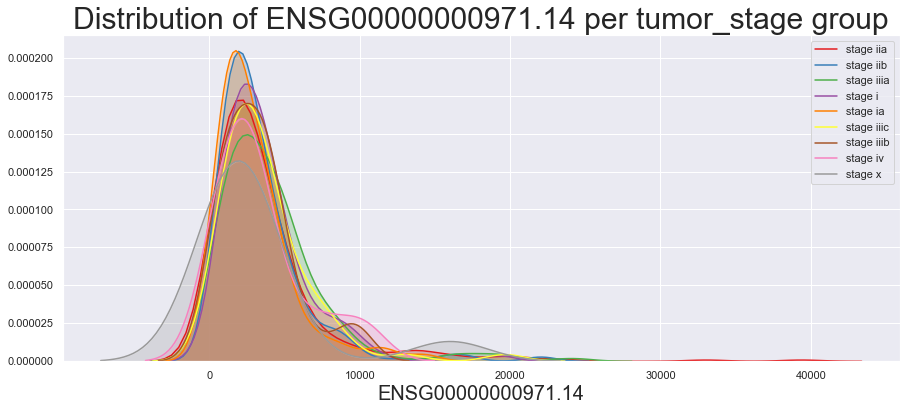

In [10]:
display_group_density_plot(groupby = 'tumor_stage', \
                           on = 'ENSG00000000971.14', \
                           df = df, \
                           figsize = (15, 6), \
                           palette = sns.color_palette('Set1'));

No handles with labels found to put in legend.


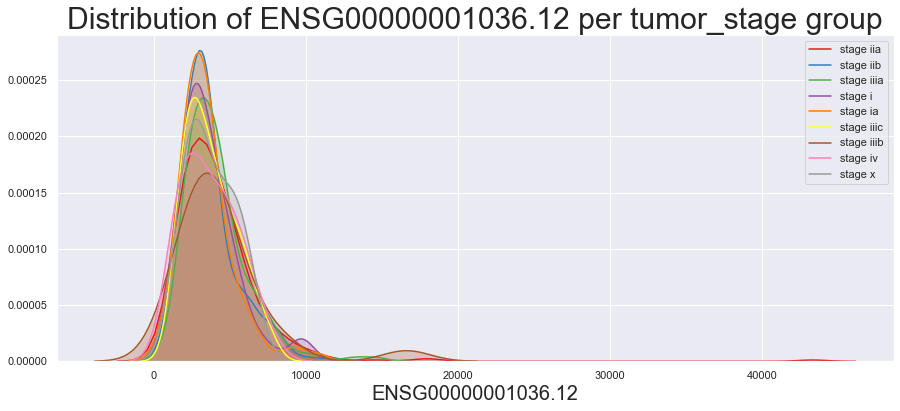

In [11]:
display_group_density_plot(groupby = 'tumor_stage', \
                           on = 'ENSG00000001036.12', \
                           df = df, \
                           figsize = (15, 6), \
                           palette = sns.color_palette('Set1'));

No handles with labels found to put in legend.


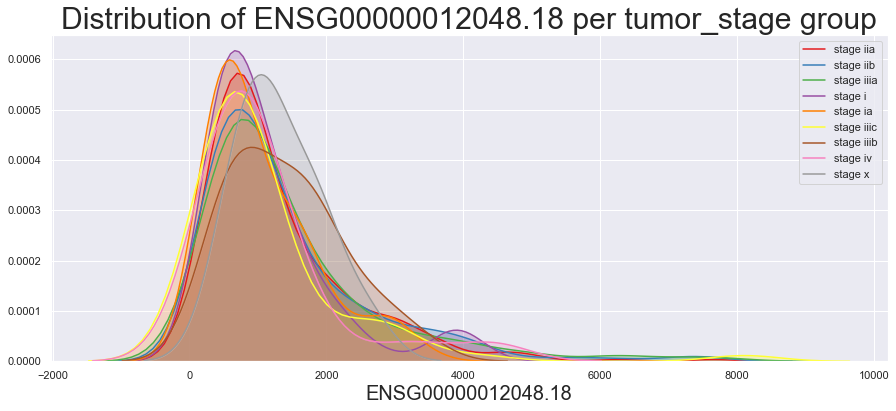

In [12]:
display_group_density_plot(groupby = 'tumor_stage', \
                           on = 'ENSG00000012048.18', \
                           df = df, \
                           figsize = (15, 6), \
                           palette = sns.color_palette('Set1'));

Check correlation between gens

# Clinical info


In [35]:
clinical = df.drop(columns=gens_indexes)
columns_to_drop = []

In [36]:
clinical.columns[3:]

Index(['year_of_diagnosis', 'classification_of_tumor',
       'last_known_disease_status', 'updated_datetime', 'primary_diagnosis',
       'submitter_id', 'tumor_stage', 'age_at_diagnosis', 'morphology',
       'days_to_last_known_disease_status', 'created_datetime',
       'prior_treatment', 'state', 'days_to_recurrence', 'diagnosis_id',
       'tumor_grade', 'treatments', 'icd_10_code', 'days_to_diagnosis',
       'tissue_or_organ_of_origin', 'progression_or_recurrence',
       'prior_malignancy', 'synchronous_malignancy',
       'site_of_resection_or_biopsy', 'days_to_last_follow_up', 'gender',
       'year_of_birth', 'race', 'days_to_birth', 'ethnicity', 'vital_status',
       'demographic_id', 'age_at_index', 'year_of_death', 'cigarettes_per_day',
       'weight', 'alcohol_history', 'alcohol_intensity', 'bmi', 'years_smoked',
       'exposure_id', 'height', '__alignment_not_unique', '__ambiguous',
       '__no_feature', '__not_aligned', '__too_low_aQual'],
      dtype='object')

## Continuous features

In [ ]:
sns.boxplot(y = 'tumor_stage', x = 'SalePrice', data = df);
plt.title('Sale Price distribution by SaleCondition')
plt.show()

## Categorical features

In [97]:
feature_uniques = clinical.nunique()
feature_uniques[feature_uniques==1]

classification_of_tumor      1
last_known_disease_status    1
state                        1
tumor_grade                  1
days_to_diagnosis            1
progression_or_recurrence    1
gender                       1
alcohol_history              1
__not_aligned                1
__too_low_aQual              1
dtype: int64

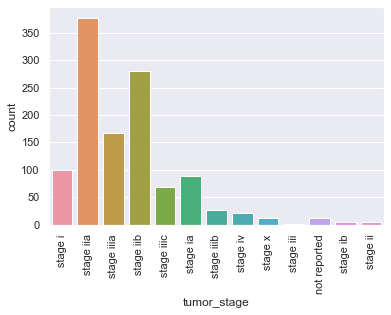

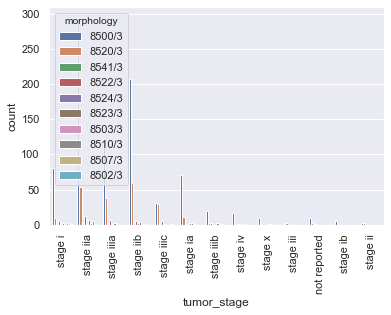

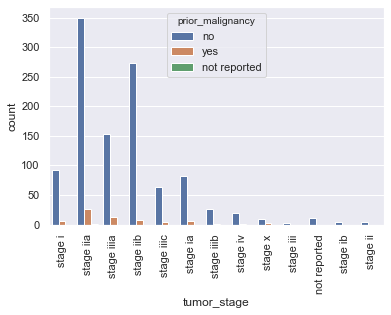

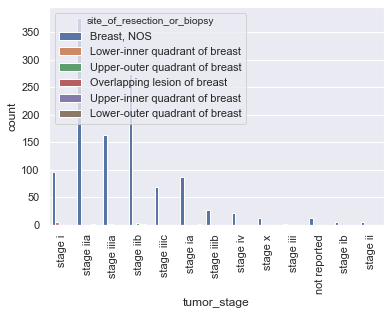

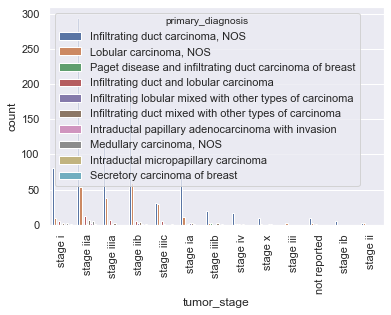

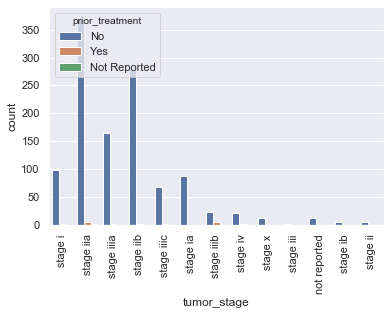

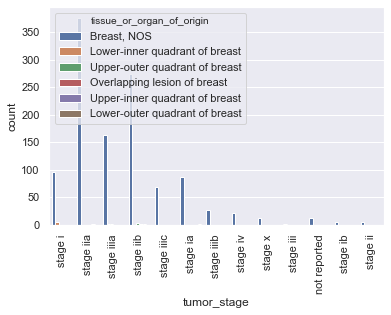

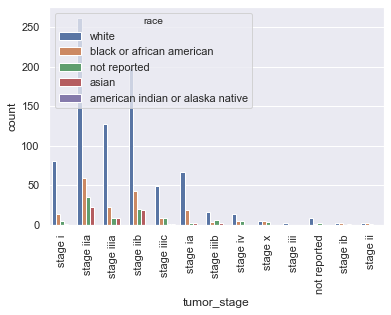

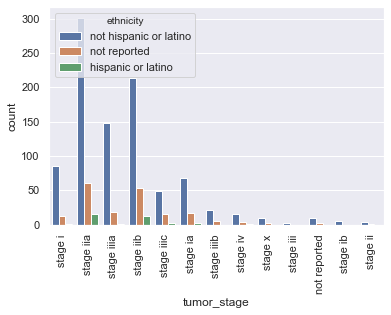

In [96]:
sns.set(style="darkgrid")

ax = sns.countplot(x = df.tumor_stage, data=df)
plt.xticks(rotation=90)
plt.show()

cat_vars = ['morphology','prior_malignancy',  'site_of_resection_or_biopsy', 'primary_diagnosis', \
            'prior_treatment', 'tissue_or_organ_of_origin', 'race', 'ethnicity']
for cat_vat in cat_vars:
    ax = sns.countplot(x = df.tumor_stage,  hue = df[cat_vat], data=df)
    plt.xticks(rotation=90)
    plt.show()

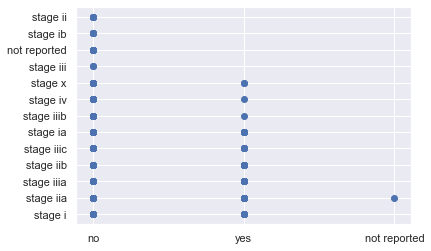

In [79]:
plt.scatter(clinical['prior_malignancy'], clinical['tumor_stage'])

## Label

In [24]:
clinical['tumor_stage'].value_counts()

stage iia       378
stage iib       280
stage iiia      167
stage i          99
stage ia         88
stage iiic       68
stage iiib       27
stage iv         21
stage x          12
not reported     12
stage ii          5
stage ib          5
stage iii         2
Name: tumor_stage, dtype: int64

## Cigarettes

In [93]:
clinical['cigarettes_per_day'].value_counts()

Series([], Name: cigarettes_per_day, dtype: int64)

We dont have info about this

In [37]:
columns_to_drop.append('cigarettes_per_day')

In [46]:
len(clinical)

1164

In [62]:
clinical['site_of_resection_or_biopsy'].value_counts()


Breast, NOS                       1148
Lower-inner quadrant of breast       6
Upper-outer quadrant of breast       5
Upper-inner quadrant of breast       2
Overlapping lesion of breast         2
Lower-outer quadrant of breast       1
Name: site_of_resection_or_biopsy, dtype: int64

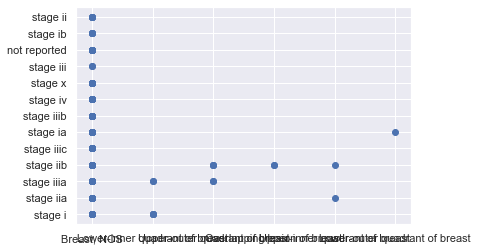

In [74]:
plt.scatter(clinical['site_of_resection_or_biopsy'], clinical['tumor_stage'])
p

In [77]:
clinical['tumor_grade'].value_counts()

not reported    1164
Name: tumor_grade, dtype: int64

I found out these 2 guys are very correlated

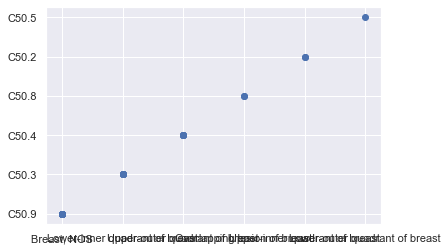

In [75]:
plt.scatter(clinical['site_of_resection_or_biopsy'], clinical['icd_10_code'])

In [76]:
clinical['site_of_resection_or_biopsy'].value_counts()

Breast, NOS                       1148
Lower-inner quadrant of breast       6
Upper-outer quadrant of breast       5
Upper-inner quadrant of breast       2
Overlapping lesion of breast         2
Lower-outer quadrant of breast       1
Name: site_of_resection_or_biopsy, dtype: int64

## ICD 10 code

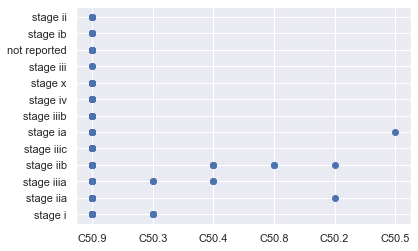

In [61]:
plt.scatter(clinical['icd_10_code'], clinical['tumor_stage'])

### Year of birth

In [20]:
df['year_of_birth'].astype(str).str.len().value_counts()

6    1162
3       2
Name: year_of_birth, dtype: int64

So there is 2 rows where the years have 3 digits

In [21]:
df[df['year_of_birth'].astype(str).str.len() == 3]['year_of_birth']

762   NaN
866   NaN
Name: year_of_birth, dtype: float64

In [18]:
df['year_of_birth'].value_counts().index

Float64Index([1953.0, 1946.0, 1948.0, 1949.0, 1964.0, 1947.0, 1951.0, 1960.0,
              1954.0, 1940.0, 1952.0, 1945.0, 1962.0, 1958.0, 1944.0, 1943.0,
              1957.0, 1950.0, 1967.0, 1941.0, 1963.0, 1939.0, 1966.0, 1955.0,
              1956.0, 1961.0, 1965.0, 1936.0, 1959.0, 1938.0, 1942.0, 1931.0,
              1928.0, 1969.0, 1933.0, 1934.0, 1930.0, 1968.0, 1929.0, 1924.0,
              1937.0, 1972.0, 1971.0, 1932.0, 1970.0, 1935.0, 1920.0, 1925.0,
              1922.0, 1927.0, 1926.0, 1919.0, 1977.0, 1974.0, 1921.0, 1973.0,
              1976.0, 1916.0, 1923.0, 1918.0, 1978.0, 1979.0, 1917.0, 1984.0,
              1913.0, 1981.0, 1983.0, 1910.0, 1909.0, 1902.0, 1914.0, 1975.0,
              1980.0],
             dtype='float64')

### Race

In [22]:
df['race'].value_counts()

white                               832
black or african american           180
not reported                         94
asian                                57
american indian or alaska native      1
Name: race, dtype: int64

What can we do with this only `american indian or alaska native` row? Drop it?

In [23]:
df['ethnicity'].value_counts()

not hispanic or latino    933
not reported              195
hispanic or latino         36
Name: ethnicity, dtype: int64

In [6]:
gens_indexes = df.columns[df.columns.str.startswith('ENSG00000012048.18')]
df[gens_indexes].head()

,ENSG00000012048.18
0,1149.0
1,3094.0
2,698.0
3,625.0
4,330.0


In [18]:
df['tumor_stage'].value_counts()[10:]

8520/3          5
not reported    5
stage ia        4
22199           4
20570           4
               ..
18594           1
19723           1
22539           1
23684           1
19805           1
Name: tumor_stage, Length: 860, dtype: int64

In [20]:
df[df['tumor_stage'] == '22199']

,Unnamed: 0,file_name,case_id,submitter_id,project_id,gender,year_of_birth,race,days_to_birth,ethnicity,...,ENSGR0000275287.3,ENSGR0000276543.3,ENSGR0000277120.3,ENSGR0000280767.1,ENSGR0000281849.1,__alignment_not_unique,__ambiguous,__no_feature,__not_aligned,__too_low_aQual
478,478,e4544c39-bf5a-4f95-8853-6a59eae4c262.htseq.cou...,b304302a-f2b9-4cd7-ab14-c21edf7778ea,TCGA-E9-A5FK,TCGA-BRCA,female,1952,white,-22199,not hispanic or latino,...,0.0,0.0,0.0,0.0,0.0,18239816.0,2702522.0,2092403.0,0.0,0.0
554,554,7e56863a-53f2-4c94-9cf0-053d72b4d5ee.htseq.cou...,14267783-5624-4fe5-ba81-9d67f1017474,TCGA-BH-A0DP,TCGA-BRCA,female,1949,white,-22199,not reported,...,0.0,0.0,0.0,0.0,0.0,13679640.0,2354170.0,2937784.0,0.0,0.0
555,555,47f0749e-01c7-4d8c-8926-06293c4a9b4e.htseq.cou...,14267783-5624-4fe5-ba81-9d67f1017474,TCGA-BH-A0DP,TCGA-BRCA,female,1949,white,-22199,not reported,...,0.0,0.0,0.0,0.0,0.0,15976607.0,2735418.0,4488922.0,0.0,0.0
772,772,95bae25e-21b8-4b27-a2da-f6ab696f674a.htseq.cou...,f43d622f-eed5-4933-adc6-ae9ad1e33028,TCGA-E2-A1IN,TCGA-BRCA,female,1950,white,-22199,not hispanic or latino,...,0.0,0.0,0.0,0.0,0.0,24789360.0,3745668.0,4822257.0,0.0,0.0


In [ ]:
sns.stripplot(x="SaleCondition", y="SalePrice", \
              data=df_house.dropna(subset=["SaleCondition"]), \
              alpha = 0.3, jitter=False);
plt.title('Sale Price distribution by SaleCondition')

plt.show()

sns.stripplot(x="SaleCondition", y="SalePrice", \
              data=df_house.dropna(subset=["SaleCondition"]), \
              alpha = 0.3, jitter=True);
plt.title('Sale Price distribution by SaleCondition')
plt.show()


# Persist it after changing it

In [86]:
df.to_csv('cleaned_dataset.csv')

KeyboardInterrupt: 